## Reading Data 

### Importing packages

In [16]:
import ccxt    # You need to install ccxt package to run the following code. Try : pip install ccxt
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

### Getting the coinpairs we want to read 

In [17]:
# List of the coins for which we have data on the transfer time

transfer_time_coins = ['BTC', 'ETH', 'LTC', 'XMR', 'DASH', 'ETC', 'ZEC', 'BTG', 'DGC', 'RDD', 'PPC', 'NVC', 'VTC', 
                       'NMC', 'FTC', 'BLK', 'AUR']  

# Function to get the common coinpairs at two different exchanges intersected with the coins for which we have data on the
# transfer time

def get_symbols(ex1, ex2, transfer_time_coins = transfer_time_coins):
    ex1_symbols = list(getattr(ccxt, ex1)().fetchTickers().keys())    # Coinpairs for the first exchange  e.g. [ETH/BTC, ADA/BTC]
    ex2_symbols = list(getattr(ccxt, ex2)().fetchTickers().keys())    # Coinpairs for the second exchange
    
    opportunity_coins = []
    for pair in (set(ex1_symbols) & set(ex2_symbols)):                # set(ex1_symbols) & set(ex2_symbols) : common coinpairs
        coin = pair[:pair.find('/')]                                  # The first coin in the coinpair  e.g [ETH, ADA]
        opportunity_coins.append(coin)                                   
        
    study_coins = set(opportunity_coins) & set(transfer_time_coins)   # List of the coins that appear in both exchanges and 
                                                                      # we have data for the transfer time  e.g [ETH]
    study_symbols = []
    for pair in (set(ex1_symbols) & set(ex2_symbols)):                # Adding the second coin  e.g [ETH/BTC]
        for coin in study_coins:
            if coin == pair[:pair.find('/')]:
                study_symbols.append(pair)
                
    return study_symbols

## Plotting 

In [22]:
# Function te get the times when opportunities appear and disappear based on the threshold for the opportunity size

def plotpair(filename, pair, threshold, steps_skipped = 1, plot = True):
    df = pd.read_csv(filename)
    df.fillna(method = 'ffill', inplace = True)
    if plot == True:
        plt.figure(figsize=(20,6))
        plt.plot(df.loc[:,['Time ' + pair]] / 60, df.loc[:,['Difference ' + pair]] * 100)
        plt.ylabel("Difference (%)")
        plt.xlabel("Time (min)")
    df_bool = (df.loc[:, ['Difference ' + pair]] * 100) > threshold

    opportunity_appear = []
    opportunity_disappear = []
    arbitragesize = []
        
    for i in range(int(len(df) / steps_skipped) - 1):
        if df_bool['Difference ' + pair][i * steps_skipped] != df_bool['Difference ' + pair][(i + 1) * steps_skipped]:
            if df_bool['Difference ' + pair][i * steps_skipped] == True:
                opportunity_disappear.append(float((df.loc[:, ["Time " + pair]].iloc[i * steps_skipped]) + (df.loc[:, ["Time " + pair]].iloc[(i + 1) * steps_skipped])) / (60 * 2))
                arbitragesize.append(float((df.loc[:, ["Difference " + pair]].iloc[i * steps_skipped]) * 100))
            else:
                opportunity_appear.append(float((df.loc[:, ["Time " + pair]].iloc[i * steps_skipped]) + (df.loc[:, ["Time " + pair]].iloc[(i + 1) * steps_skipped])) / (60 * 2))
    if plot == True:            
        plt.axhline(y = threshold, color = "black")
        for x in opportunity_appear:
            plt.axvline(float(x), color = "green")
        for x in opportunity_disappear:
            plt.axvline(float(x), color = "red")
        plt.show()
        
    return opportunity_appear, opportunity_disappear, arbitragesize

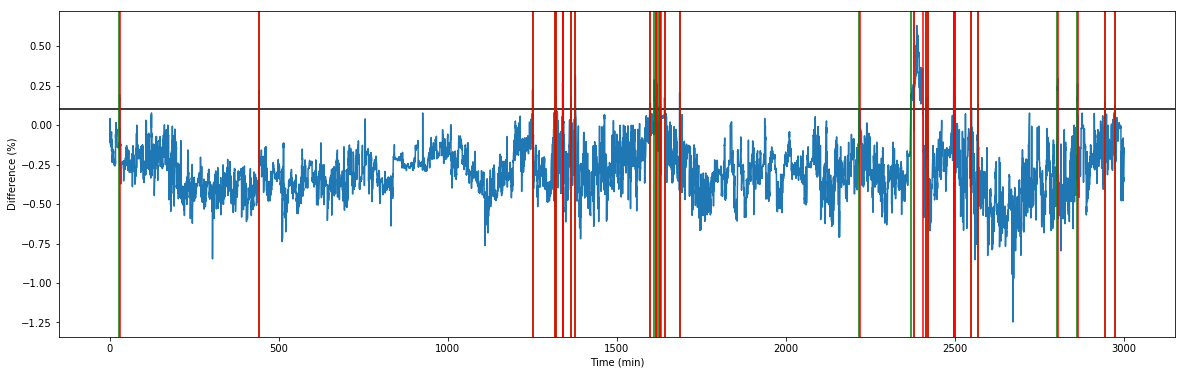

([29.146943453947703,
  441.4035436153412,
  1250.609101019303,
  1317.9697127997874,
  1320.1074691136678,
  1339.4227696975072,
  1341.1386672993501,
  1363.6552061398825,
  1376.8683650771777,
  1596.6560951113702,
  1610.5492621243,
  1616.0951072990895,
  1624.87570378383,
  1627.823843560616,
  1640.7832932531833,
  1685.21471585234,
  2215.473357109229,
  2368.909797539314,
  2379.0967659652233,
  2413.4881778021654,
  2418.4207413534323,
  2495.4775986830396,
  2496.3278560578824,
  2497.9671217143537,
  2499.1387270410855,
  2548.184641738733,
  2566.779150058826,
  2802.0356744786104,
  2861.0077166755996,
  2942.190504040321,
  2973.40782110095],
 [30.132883644104005,
  441.63413848280913,
  1250.8689161916575,
  1318.2715709308784,
  1320.377646289269,
  1339.6858382682005,
  1341.3974677920341,
  1363.9101181427638,
  1377.4849872330824,
  1599.281452780962,
  1615.6267100791135,
  1618.8177327573298,
  1626.0819331129392,
  1629.0124329467615,
  1641.0432237704595,
  1685

In [26]:
plotpair('binance_kraken_0.1_3000', 'XMR/BTC', 0.1)

## Frequency function 

In [46]:
# Getting the density histogram for the opportunity times (V(hat))

def freq(filename, pair, threshold, steps_skipped = 1, plot = False, freq = True):
    a, b, difference = plotpair(filename, pair, threshold, steps_skipped = 1, plot = plot) # a is opportunity_apear, b is opportunity_disappear
    count = 0
    durations = []
    
    if (len(a) > 0 or len(b) > 0):
        if len(a) != len(b):
            for i in range (min(len(a), len(b))):
                if a[0] < b[0]: # opportunity appear[0]< opportunity dissapear[0]
                    count += 1
                    durations.append(round((b[i] - a[i]), 3))
                else:
                    count += 1
                    durations.append(round((b[i + 1] - a[i]), 3))
        else:
            if a[0] < b[0]:
                for i in range (len(a)):
                    count += 1
                    durations.append(round((b[i] - a[i]), 3))
            else:
                for i in range(1, len(a)):
                    count += 1
                    durations.append(round((b[i] - a[i - 1])))
    durationdifference = [] # putting duration of opportunity and percentage difference together
    for value in range(len(durations)):
        durationdifference.append([durations[value], difference[value]])

    if freq == True:
        #plt.figure(figsize=(20,6))
        plt.hist(durations, bins = 50, density = True)
        plt.ylabel("Density")
        plt.xlabel("Time (min)")
        plt.title("Histogram of densities for: " + str(filename) + pair)
        plt.show()
        
    print('Number of opportunities: {0}'.format(len(durations)))
    return durations, difference, durationdifference

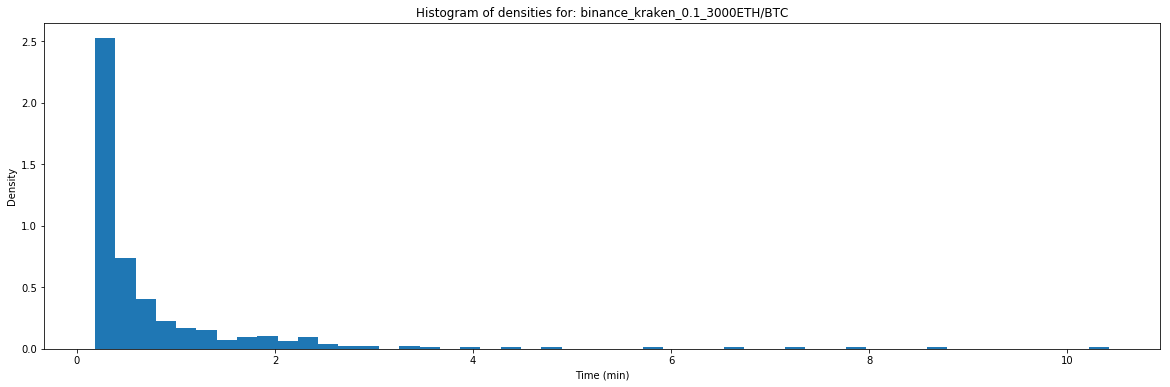

Number of opportunities: 408


([0.252,
  0.678,
  1.778,
  0.672,
  0.215,
  1.024,
  0.257,
  0.958,
  0.224,
  0.933,
  1.351,
  0.238,
  1.428,
  0.222,
  0.224,
  0.224,
  0.508,
  0.257,
  0.238,
  0.231,
  0.245,
  0.313,
  0.252,
  0.494,
  0.448,
  0.25,
  0.49,
  0.511,
  0.323,
  3.56,
  1.202,
  0.549,
  1.069,
  1.566,
  0.456,
  0.962,
  0.259,
  0.236,
  2.256,
  0.256,
  0.265,
  0.559,
  0.303,
  1.381,
  0.579,
  0.481,
  0.825,
  0.259,
  0.273,
  0.276,
  0.804,
  1.384,
  0.3,
  1.34,
  0.258,
  1.909,
  0.784,
  2.27,
  1.819,
  0.517,
  0.872,
  0.304,
  0.263,
  0.319,
  0.249,
  0.253,
  0.496,
  0.234,
  1.455,
  0.724,
  0.239,
  0.222,
  1.062,
  0.216,
  0.239,
  0.44,
  0.273,
  0.251,
  0.48,
  0.466,
  0.261,
  0.318,
  0.254,
  0.248,
  1.644,
  2.092,
  0.742,
  2.873,
  0.315,
  0.791,
  3.008,
  2.404,
  1.937,
  1.548,
  0.459,
  2.102,
  10.428,
  0.291,
  0.218,
  0.376,
  0.475,
  0.328,
  0.355,
  2.159,
  1.409,
  1.014,
  4.875,
  0.426,
  0.504,
  1.419,
  2.062,
  7.821,


In [30]:
freq('binance_kraken_0.1_3000', 'ETH/BTC', 0)  # This is V(hat)

### Data for the transfer times (V*) 

In [5]:
# Data from bitinfocharts.com as of 20.11.2018 for the past 30 days
bitcoin = {'Name': 'Bitcoin', 'Symbol': 'BTC', 'Market Cap': 77823843365, 'Mean Block Time': 10.99, 'Std Block Time': 1.95, 'Conf kraken': 6, 'Conf okex': 1, 'Conf poloniex': 1}
ethereum = {'Name': 'Ethereum', 'Symbol': 'ETH', 'Market Cap': 13908857615, 'Mean Block Time': 0.24, 'Std Block Time': 0.003, 'Conf kraken': 30, 'Conf okex': 12, 'Conf poloniex': 30}
bitcoin_cash = {'Name': 'Bitcoin Cash', 'Symbol': 'BCH', 'Market Cap': 4117199610, 'Mean Block Time': 11.33, 'Std Block Time': 1.5, 'Conf kraken': 15, 'Conf okex': 1, 'Conf poloniex': 2}
litecoin = {'Name': 'Litecoin', 'Symbol': 'LTC', 'Market Cap': 1984028729, 'Mean Block Time': 2.86, 'Std Block Time': 0.24, 'Conf kraken': 12, 'Conf okex': 1, 'Conf poloniex': 4}
monero = {'Name': 'Monero', 'Symbol': 'XMR', 'Market Cap': 1105984805, 'Mean Block Time': 2.05, 'Std Block Time': 0.19, 'Conf kraken': 15, 'Conf okex': 6, 'Conf poloniex': 8}
dash = {'Name': 'Dash', 'Symbol': 'DASH', 'Market Cap': 893429869, 'Mean Block Time': 2.67, 'Std Block Time': 0.037, 'Conf kraken': 6, 'Conf okex': 6, 'Conf poloniex': 6}
ethereum_classic = {'Name': 'Ethereum Classic', 'Symbol': 'ETC', 'Market Cap': 592807463, 'Mean Block Time': 0.235, 'Std Block Time': 0.004, 'Conf kraken': 120, 'Conf okex': 30, 'Conf poloniex': 30}
zcash = {'Name': 'Zcash', 'Symbol': 'ZEC', 'Market Cap': 444573706, 'Mean Block Time': 2.5, 'Std Block Time': 0.059, 'Conf kraken': 24, 'Conf okex': 15, 'Conf poloniex': 8}
bitcoin_gold = {'Name': 'Bitcoin Gold', 'Symbol': 'BTG', 'Market Cap': 350034089, 'Mean Block Time': 9.35, 'Std Block Time': 0.63, 'Conf kraken': 10000, 'Conf okex': 2, 'Conf poloniex': 10000}
dogecoin = {'Name': 'Dogecoin', 'Symbol': 'DGC', 'Market Cap': 263966877, 'Mean Block Time': 1.05, 'Std Block Time': 0.01, 'Conf kraken': 20, 'Conf okex': 10000, 'Conf poloniex': 6}
reddcoin = {'Name': 'Reddcoin', 'Symbol': 'RDD', 'Market Cap': 45924208, 'Mean Block Time': 0.98, 'Std Block Time': 0.048, 'Conf kraken': 10000, 'Conf okex': 10000, 'Conf poloniex': 10000}
peercoin = {'Name': 'Peercoin', 'Symbol': 'PPC', 'Market Cap': 20335462, 'Mean Block Time': 8.42, 'Std Block Time': 1.89, 'Conf kraken': 10000, 'Conf okex': 10000, 'Conf poloniex': 6}
novacoin = {'Name': 'Novacoin', 'Symbol': 'NVC', 'Market Cap': 15748331, 'Mean Block Time': 6.32, 'Std Block Time': 1.28, 'Conf kraken': 10000, 'Conf okex': 10000, 'Conf poloniex': 10000}
vertcoin = {'Name': 'Vertcoin', 'Symbol': 'VTC', 'Market Cap': 14777987, 'Mean Block Time': 2.3, 'Std Block Time': 0.255, 'Conf kraken': 10000, 'Conf okex': 10000, 'Conf poloniex': 10000}
namecoin = {'Name': 'Namecoin', 'Symbol': 'NMC', 'Market Cap': 6112251, 'Mean Block Time': 11.52, 'Std Block Time': 2.23, 'Conf kraken': 10000, 'Conf okex': 10000, 'Conf poloniex': 8}
feathercoin = {'Name': 'Feathercoin', 'Symbol': 'FTC', 'Market Cap': 4322142, 'Mean Block Time': 1.22, 'Std Block Time': 0.22, 'Conf kraken': 10000, 'Conf okex': 10000, 'Conf poloniex': 10000}
blackcoin = {'Name': 'Blackcoin', 'Symbol': 'BLK', 'Market Cap': 3625562, 'Mean Block Time': 1.12, 'Std Block Time': 0.007, 'Conf kraken': 10000, 'Conf okex': 10000, 'Conf poloniex': 10000}
auroracoin = {'Name': 'Auroracoin', 'Symbol': 'AUR', 'Market Cap': 1588197, 'Mean Block Time': 0.89, 'Std Block Time': 0.07, 'Conf kraken': 10000, 'Conf okex': 10000, 'Conf poloniex': 10000}

In [31]:
l = [bitcoin, ethereum, bitcoin_cash, litecoin, monero, dash, ethereum_classic, zcash, bitcoin_gold, dogecoin, reddcoin, 
     peercoin, novacoin, vertcoin, namecoin, feathercoin, blackcoin, auroracoin]
df = pd.DataFrame(l, columns=['Name', 'Symbol', 'Market Cap', "Mean Block Time", 'Std Block Time', 
                              'Conf kraken', 'Conf okex', 'Conf poloniex']).set_index(['Symbol'])
df  # 10000 confirmations mean missing values

,Name,Market Cap,Mean Block Time,Std Block Time,Conf kraken,Conf okex,Conf poloniex
Symbol,,,,,,,
BTC,Bitcoin,77823843365,10.990,1.950,6,1,1
ETH,Ethereum,13908857615,0.240,0.003,30,12,30
BCH,Bitcoin Cash,4117199610,11.330,1.500,15,1,2
LTC,Litecoin,1984028729,2.860,0.240,12,1,4
XMR,Monero,1105984805,2.050,0.190,15,6,8
DASH,Dash,893429869,2.670,0.037,6,6,6
ETC,Ethereum Classic,592807463,0.235,0.004,120,30,30
ZEC,Zcash,444573706,2.500,0.059,24,15,8
BTG,Bitcoin Gold,350034089,9.350,0.630,10000,2,10000


### Testing hypothesis

Mann-Whitney U Test 

Tests whether the distributions of two independent samples are equal or not.

Assumptions:

Observations in each sample are independent and identically distributed (iid).

Observations in each sample can be ranked.

Interpretation:

H0: the distributions of both samples are equal.

H1: the distributions of both samples are not equal.

In [47]:
def hypothesis_tests(filename, ex1, ex2, plot1 = False, freq1 = False):
    pairs = get_symbols(ex1, ex2)
    p_values = []
    for pair in pairs:
            transfer_coin = pair[:pair.find('/')]
            dist = df.loc[transfer_coin, ['Mean Block Time', 'Std Block Time', 'Conf ' + ex2]]
            transfer_time_distribution = np.random.normal(loc = dist[0] * dist[2], scale = dist[1] * dist[2], size = 10000)
            plt.figure(figsize=(20,6))
            plt.hist(transfer_time_distribution, bins = 50, density = True)
            opportunity_time_distribution , b, c = freq(filename, pair, 0, plot = plot1, freq = freq1)
            p = mannwhitneyu(transfer_time_distribution, opportunity_time_distribution, alternative = 'less')
            p_values.append(p[1])
            print(p)
    return pairs, p_values

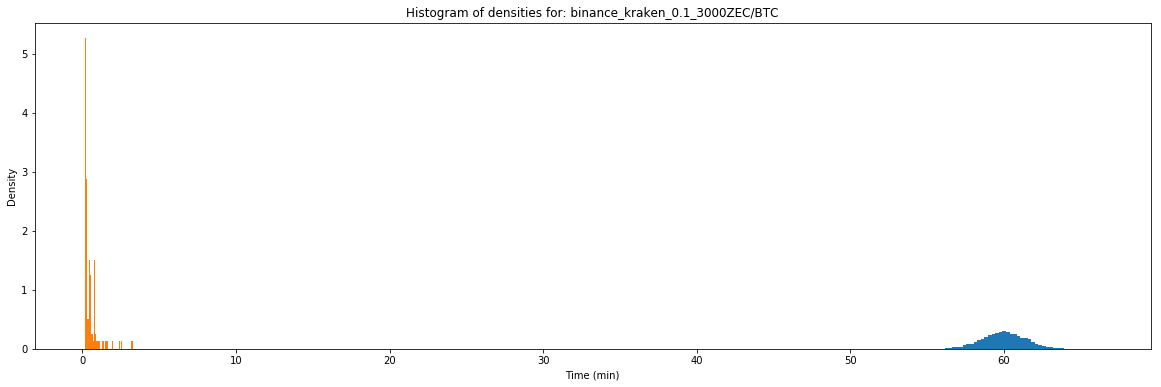

Number of opportunities: 129
MannwhitneyuResult(statistic=1290000.0, pvalue=1.0)


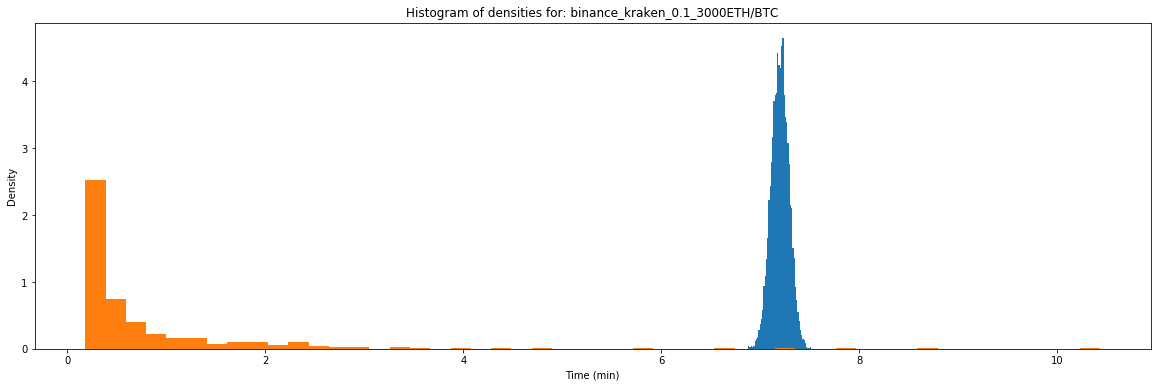

Number of opportunities: 408
MannwhitneyuResult(statistic=4045411.0, pvalue=1.0)


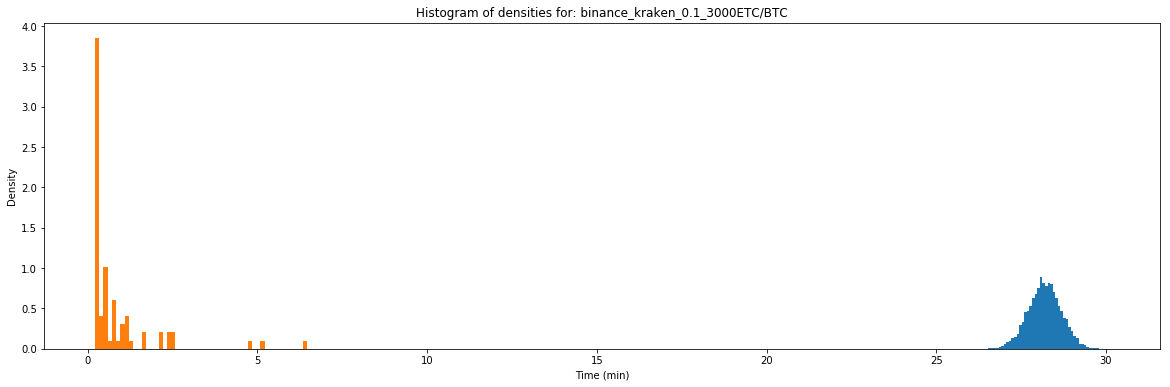

Number of opportunities: 79
MannwhitneyuResult(statistic=790000.0, pvalue=1.0)


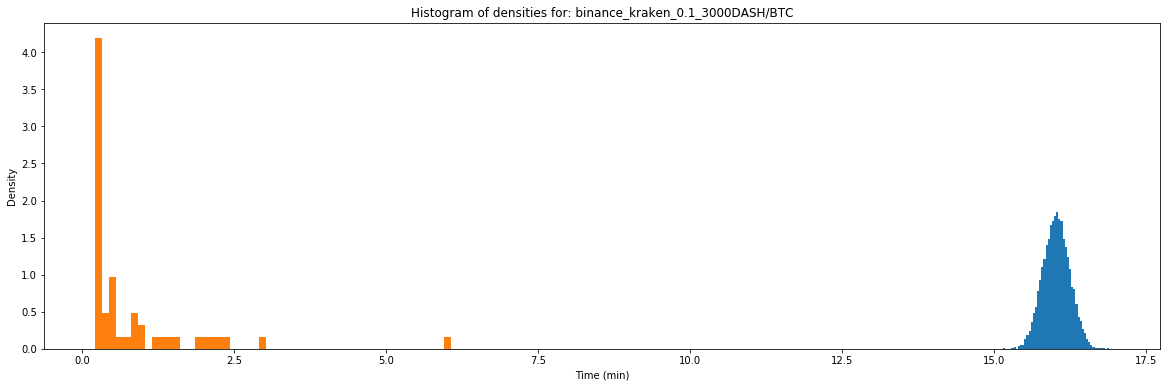

Number of opportunities: 53
MannwhitneyuResult(statistic=530000.0, pvalue=1.0)


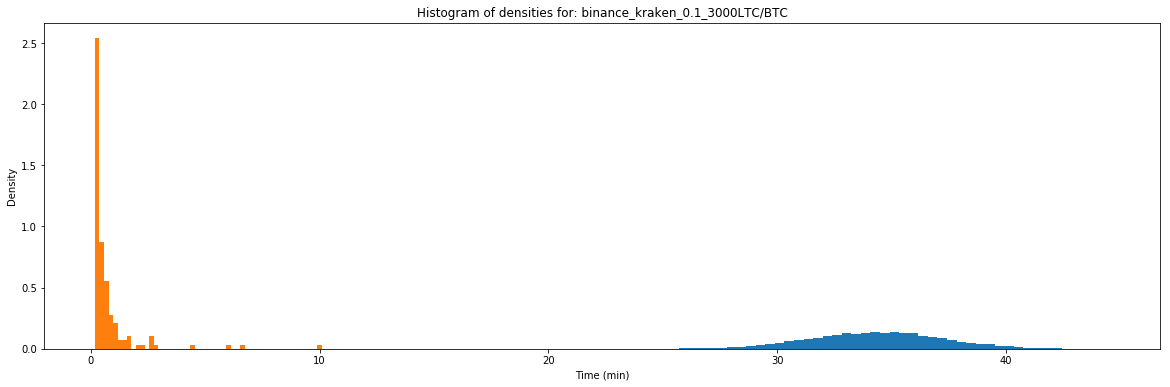

Number of opportunities: 145
MannwhitneyuResult(statistic=1450000.0, pvalue=1.0)


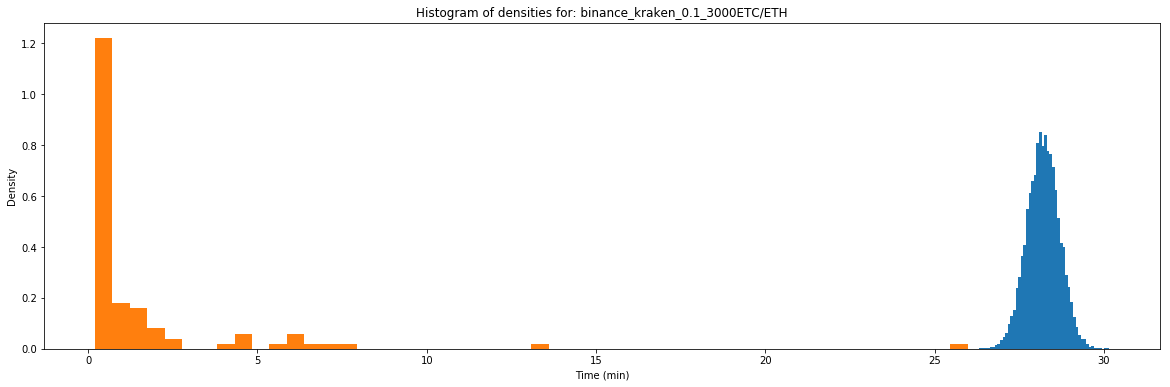

Number of opportunities: 97
MannwhitneyuResult(statistic=970000.0, pvalue=1.0)


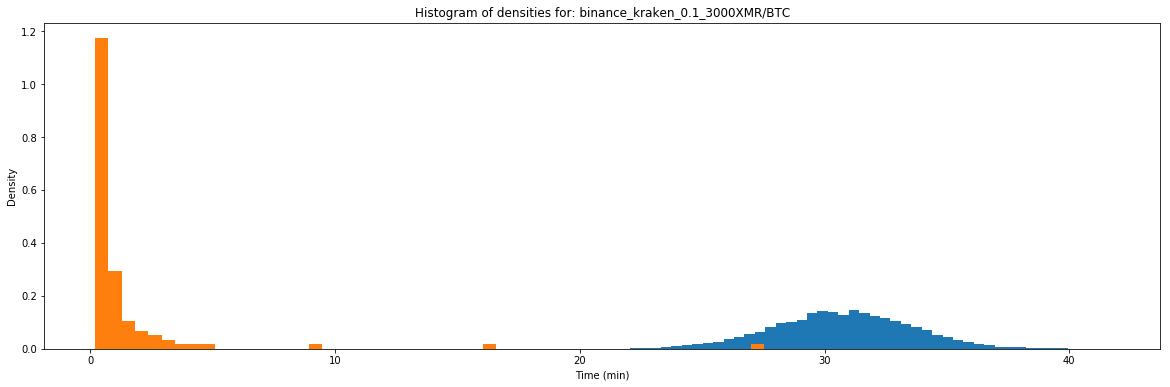

Number of opportunities: 106
MannwhitneyuResult(statistic=1058730.0, pvalue=1.0)


In [48]:
a, b = hypothesis_tests('binance_kraken_0.1_3000', 'binance', 'kraken', freq1 = True)

## Pivoting 

In [49]:
#the idea of pivoting comes after not rejecting null hypothesis, and it is based on reasoning that we do not 
# have to execute trade at the same moment opportunity appeared.

#Because if we wait for some time (as we can see in scatter plot at the end), the opportunity time might increase.



## Cumulative duration 

In [8]:
def cumdur(minutes, filename, pairs, threshold):
    cumdur = []
    waiting = []
    timeleft = []
    pairdurationsize = []
    for pair in pairs:
        (a, b, c) = freq(filename, pair, threshold)
        for value in range(len(a)):
            if a[value] > minutes: 
                cumdur.append(a[value])
                pairdurationsize.append([pair, c[value]])
    cumdur = np.array(cumdur)
        
    plt.show()
    plt.title(pairs)
    plt.xlabel('Durations (min)')
    plt.ylabel('Frequency')
    plt.hist(cumdur)
    
    #print(pairdurationsize)
    #print("number of opportunitites: ", len(cumdur))
    #print("time to conduct arbitrage:", cumdur.mean() - minutes)
    waiting.append(minutes)
    timeleft.append(cumdur.mean() - minutes)
    
    return waiting, timeleft, pairdurationsize, len(cumdur)

In [21]:
def coinhist(minutes, filename, pairs, threshold):
    a, b, pairdurationsize = cumdur(minutes, filename, pairs, threshold)
    return  pairdurationsize

## Time to conduct arbitrage 

### Plotting time remaining to conduct arbitrage binancekraken waiting times 1-20

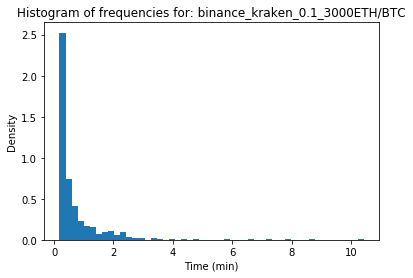

Number of opportunities: 408


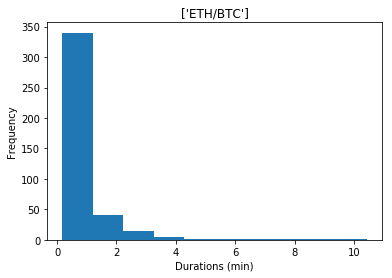

[408]


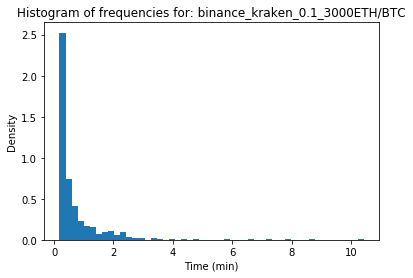

Number of opportunities: 408


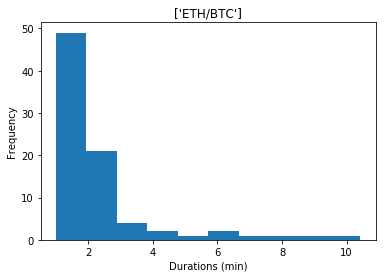

[408, 83]


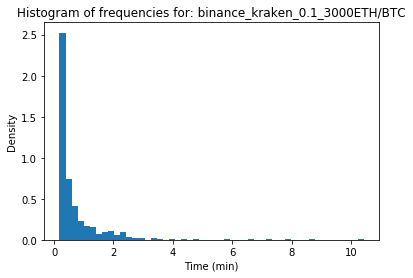

Number of opportunities: 408


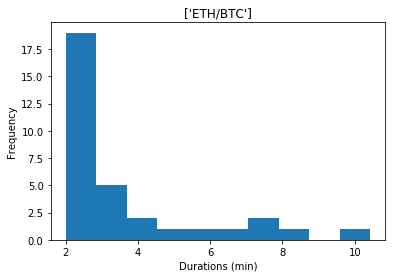

[408, 83, 33]


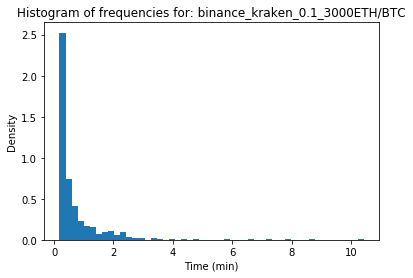

Number of opportunities: 408


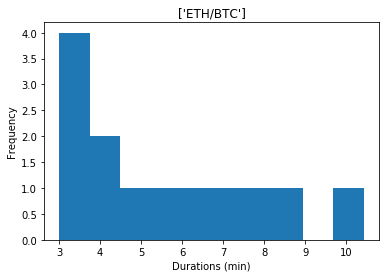

[408, 83, 33, 13]


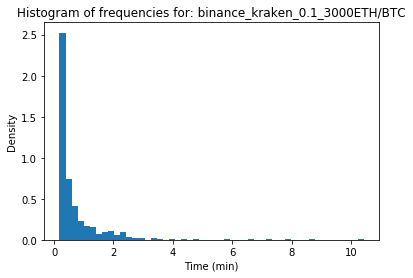

Number of opportunities: 408


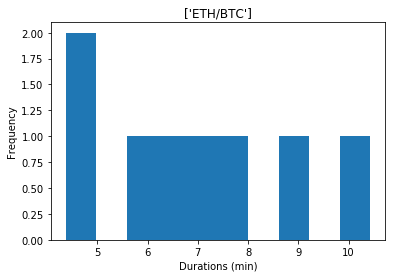

[408, 83, 33, 13, 8]


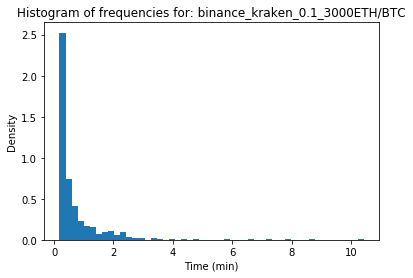

Number of opportunities: 408


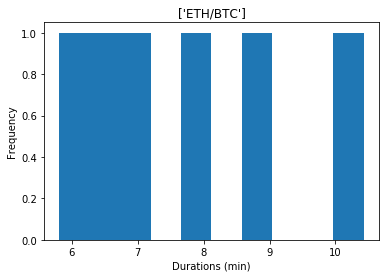

[408, 83, 33, 13, 8, 6]


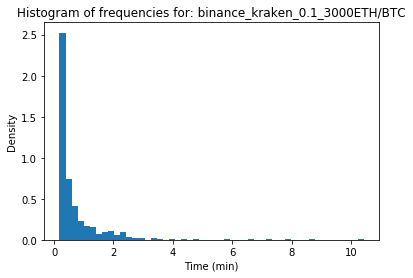

Number of opportunities: 408


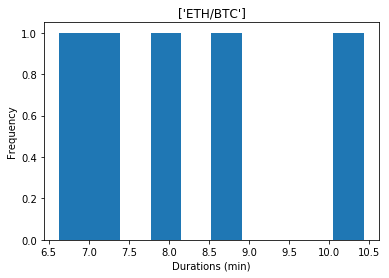

[408, 83, 33, 13, 8, 6, 5]


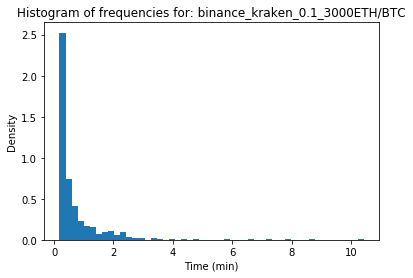

Number of opportunities: 408


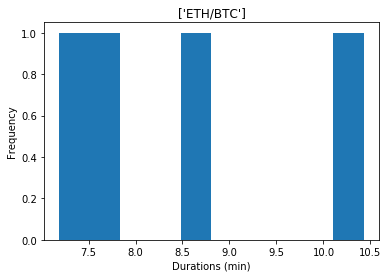

[408, 83, 33, 13, 8, 6, 5, 4]


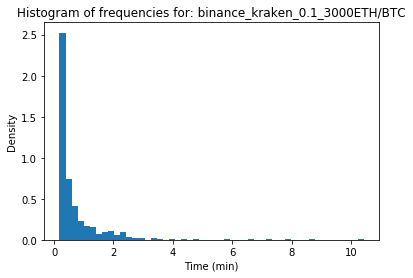

Number of opportunities: 408


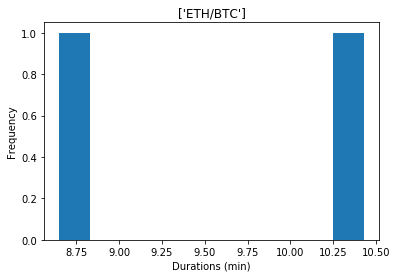

[408, 83, 33, 13, 8, 6, 5, 4, 2]


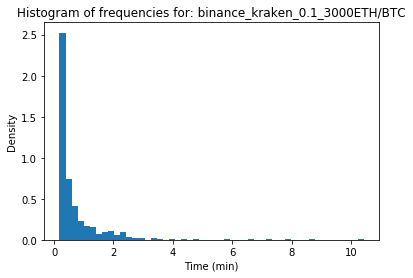

Number of opportunities: 408


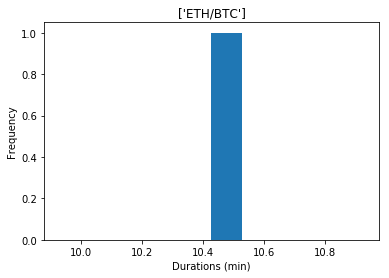

[408, 83, 33, 13, 8, 6, 5, 4, 2, 1]


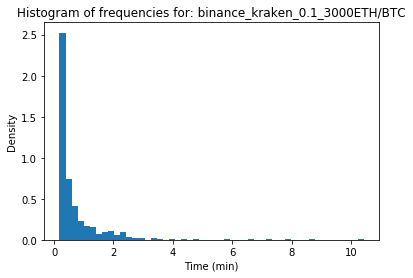

Number of opportunities: 408


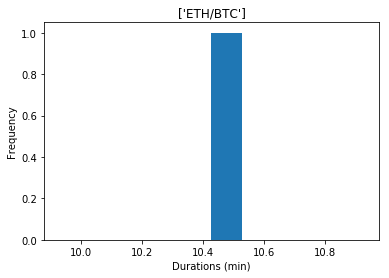

[408, 83, 33, 13, 8, 6, 5, 4, 2, 1, 1]


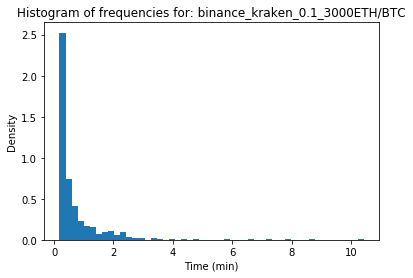

Number of opportunities: 408


C:\Users\elton\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\elton\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


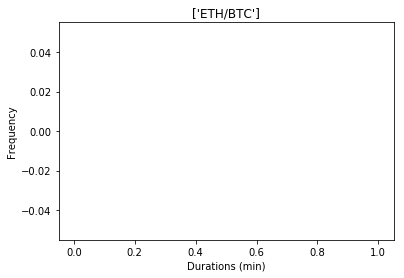

[408, 83, 33, 13, 8, 6, 5, 4, 2, 1, 1, 0]


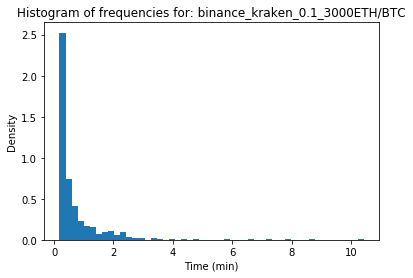

Number of opportunities: 408


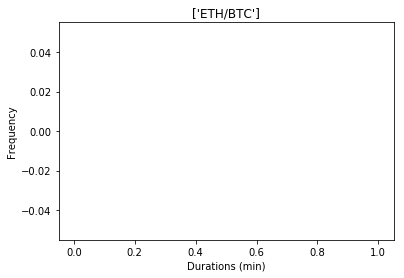

[408, 83, 33, 13, 8, 6, 5, 4, 2, 1, 1, 0, 0]


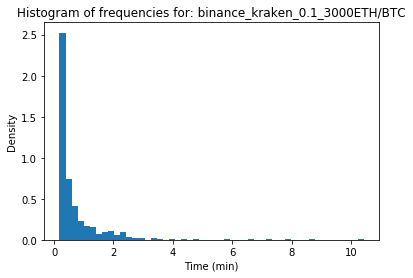

Number of opportunities: 408


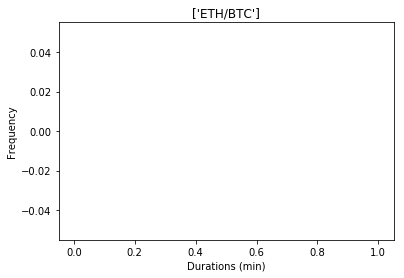

[408, 83, 33, 13, 8, 6, 5, 4, 2, 1, 1, 0, 0, 0]


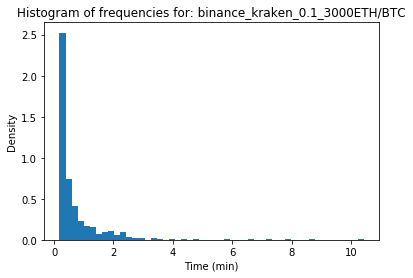

Number of opportunities: 408


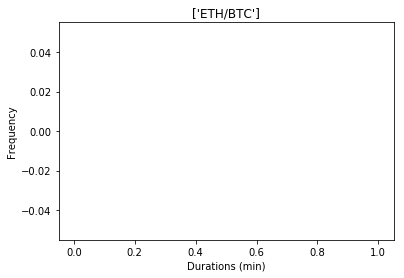

[408, 83, 33, 13, 8, 6, 5, 4, 2, 1, 1, 0, 0, 0, 0]


In [9]:
waiting = []
timeleft = []
op = []
for i in range(0, 15):
    wait, left, pairdurationsize, d = cumdur(i, 'binance_kraken_0.1_3000', ['ETH/BTC'], 0)
    waiting.append(wait)
    timeleft.append(left)
    op.append(d)
    plt.show()
    print(op)

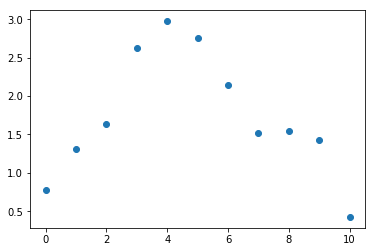

   [408, 83, 33, 13, 8, 6, 5, 4, 2, 1, 1]


In [17]:
plt.scatter(waiting, timeleft)
plt.figaspect()
plt.show()
print('  ', op[:11])